In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Dropout, ReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
import tensorflow as tf
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import CosineDecay
import matplotlib.pyplot as plt

In [2]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


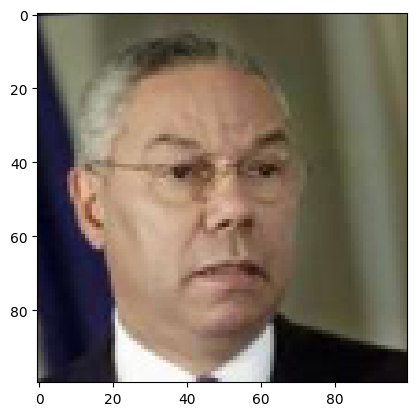

In [3]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))


## View some images
plt.imshow(x_train[0,:,:,: ] )
plt.show()

In [4]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

num_classes = 2
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [5]:
datagen = ImageDataGenerator(
  width_shift_range=0.3,
  shear_range = 0.2,
  height_shift_range=0.3,
  rotation_range=10,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

In [6]:
## DEF A BLOCK CONV + BN + GN + CONV + BN + GN + MAXPOOL 
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.1))
  # model.add(Dropout(0.1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters, (3, 3), padding='same'))
  model.add(BN())
  model.add(GN(0.1))
  # model.add(Dropout(0.1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  return model

In [7]:
batch_size = 32
epochs = 150

# Large Model

In [8]:
model = Sequential()

model=CBGN(model,64,x_train.shape[1:])
model=CBGN(model,128)
model=CBGN(model,256)
model.add(keras.layers.GlobalAveragePooling2D())
# model.add(Flatten())
model.add(Dense(256))
# model.add(GN(0.1))
model.add(Dropout(0.1))
model.add(ReLU())
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 100, 100, 64)     0         
 se)                                                             
                                                                 
 activation (Activation)     (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                        

In [9]:
## OPTIM AND COMPILE
decay_steps = epochs*len(x_train)
print(decay_steps)
lr = CosineDecay(0.1, int(decay_steps*0.8), 0.0001)
opt = SGD(learning_rate=lr, 
          # decay=1e-6
          momentum=0.9,
          decay=5e-4
          )
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=opt,
              metrics=['accuracy'])

1587750


In [10]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
print(class_wts)
class_wts = {0:0.64511214, 1:2.22280554}

[0.64511214 2.22280554]


In [11]:
## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop],
                            verbose=1,
                            # class_weight=class_wts
                  )

Epoch 1/150
330/330 [==============================] - 49s 136ms/step - loss: 0.5457 - accuracy: 0.7691 - val_loss: 0.5148 - val_accuracy: 0.7749
Epoch 2/150
330/330 [==============================] - 32s 96ms/step - loss: 0.4746 - accuracy: 0.7823 - val_loss: 0.6558 - val_accuracy: 0.7749
Epoch 3/150
330/330 [==============================] - 34s 102ms/step - loss: 0.4301 - accuracy: 0.8038 - val_loss: 0.3869 - val_accuracy: 0.8172
Epoch 4/150
330/330 [==============================] - 32s 97ms/step - loss: 0.3823 - accuracy: 0.8265 - val_loss: 0.3588 - val_accuracy: 0.8516
Epoch 5/150
330/330 [==============================] - 33s 101ms/step - loss: 0.3411 - accuracy: 0.8529 - val_loss: 0.3662 - val_accuracy: 0.8505
Epoch 6/150
330/330 [==============================] - 34s 101ms/step - loss: 0.2760 - accuracy: 0.8854 - val_loss: 0.2886 - val_accuracy: 0.8644
Epoch 7/150
330/330 [==============================] - 32s 97ms/step - loss: 0.2409 - accuracy: 0.9008 - val_loss: 0.2060 - va

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=2, 
    min_lr=0.000001,
    verbose=2
)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=opt,
              metrics=['accuracy'])
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop, reduce_lr],
                            verbose=1,
                            class_weight=class_wts)

Epoch 1/150
330/330 [==============================] - 40s 105ms/step - loss: 0.0321 - accuracy: 0.9881 - val_loss: 0.0824 - val_accuracy: 0.9785 - lr: 1.0000e-04
Epoch 2/150
330/330 [==============================] - 32s 98ms/step - loss: 0.0336 - accuracy: 0.9861 - val_loss: 0.0771 - val_accuracy: 0.9796 - lr: 1.0000e-04
Epoch 3/150
330/330 [==============================] - 33s 101ms/step - loss: 0.0317 - accuracy: 0.9867 - val_loss: 0.0833 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 4/150
331/330 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9871
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
330/330 [==============================] - 33s 99ms/step - loss: 0.0299 - accuracy: 0.9871 - val_loss: 0.0874 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 5/150
330/330 [==============================] - 33s 101ms/step - loss: 0.0281 - accuracy: 0.9881 - val_loss: 0.0795 - val_accuracy: 0.9800 - lr: 1.0000e-05
Epoch 6/150
331/330 [=====

# Small Model

In [14]:
model = Sequential()

model=CBGN(model,16,x_train.shape[1:])
model=CBGN(model,32)
model=CBGN(model,64)
model.add(keras.layers.GlobalAveragePooling2D())
# model.add(Flatten())
model.add(Dense(64))
# model.add(GN(0.1))
model.add(Dropout(0.1))
model.add(ReLU())
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 16)     64        
 hNormalization)                                                 
                                                                 
 gaussian_noise_6 (GaussianN  (None, 100, 100, 16)     0         
 oise)                                                           
                                                                 
 activation_7 (Activation)   (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                      

In [15]:
## OPTIM AND COMPILE
decay_steps = epochs*len(x_train)
print(decay_steps)
lr = CosineDecay(0.1, int(decay_steps*0.8), 0.0001)
opt = SGD(learning_rate=lr, 
          # decay=1e-6
          momentum=0.9,
          decay=5e-4
          )
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=opt,
              metrics=['accuracy'])

1587750


In [16]:
## TRAINING with DA and LRA
history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop],
                            verbose=1,
                  )

Epoch 1/150
330/330 [==============================] - 34s 98ms/step - loss: 0.4859 - accuracy: 0.7754 - val_loss: 0.5002 - val_accuracy: 0.7764
Epoch 2/150
330/330 [==============================] - 30s 90ms/step - loss: 0.4269 - accuracy: 0.8002 - val_loss: 0.4126 - val_accuracy: 0.7931
Epoch 3/150
330/330 [==============================] - 32s 95ms/step - loss: 0.3852 - accuracy: 0.8217 - val_loss: 0.4552 - val_accuracy: 0.8285
Epoch 4/150
330/330 [==============================] - 29s 88ms/step - loss: 0.3476 - accuracy: 0.8489 - val_loss: 0.3008 - val_accuracy: 0.8678
Epoch 5/150
330/330 [==============================] - 30s 90ms/step - loss: 0.3065 - accuracy: 0.8722 - val_loss: 0.4802 - val_accuracy: 0.7870
Epoch 6/150
330/330 [==============================] - 30s 91ms/step - loss: 0.2640 - accuracy: 0.8894 - val_loss: 0.3349 - val_accuracy: 0.8391
Epoch 7/150
330/330 [==============================] - 29s 88ms/step - loss: 0.2325 - accuracy: 0.9051 - val_loss: 0.4124 - val_ac